# INFERENCE

In [1]:
import numpy as np
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path="G_nat.tflite")
interpreter.allocate_tensors()

2024-05-30 15:47:22.058679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 15:47:22.058724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 15:47:22.059797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 15:47:22.066709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 15:47:22.866888: W tensorflow/compiler/tf2

In [2]:
from outpainting import construct_masked

In [3]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [4]:
input_details

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1,   3, 192, 192], dtype=int32),
  'shape_signature': array([ -1,   3, 192, 192], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [5]:
input_shape = input_details[0]['shape']
from PIL import Image

image_path = "./refer/1.JPG"
image = Image.open(image_path)
new_size = (192, 192)
image_resized = image.resize(new_size)
init_image_np = np.array(image_resized).astype(np.float32) / 255.0
#init_image_np = np.expand_dims(init_image_np, axis=0).transpose(0, 3, 1, 2)

In [6]:
import skimage
input_size = 128
output_size = 192
expand_size = (output_size - input_size) // 2

resized = skimage.transform.resize(init_image_np, (input_size, input_size), anti_aliasing=True)
masked_img = np.ones((output_size, output_size, 3))
masked_img[expand_size:-expand_size, expand_size:-expand_size, :] = resized

In [7]:
masked_img = np.expand_dims(masked_img, axis=0).astype(np.float32).transpose(0, 3, 1, 2)

In [8]:
interpreter.set_tensor(input_details[0]['index'], masked_img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [9]:
print("Output data range:", np.min(output_data), np.max(output_data))
output_data = (output_data - np.min(output_data)) / (np.max(output_data) - np.min(output_data))
output_data = output_data * 255.0
output_data = output_data.astype(np.uint8)
output_image = Image.fromarray(output_data[0].transpose(1, 2, 0))

Output data range: -0.1422966 0.9999989


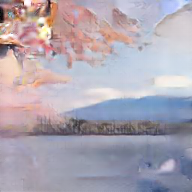

In [10]:
output_image

## ORIGINAL MODEL

In [11]:
import torch
import torch.onnx
from outpainting import load_model, perform_outpaint
import matplotlib.pyplot as plt

gen_model = load_model('G_nat.pt')
input_img = plt.imread('./refer/1.JPG')[:, :, :3]
_, output = perform_outpaint(gen_model, input_img)
#output = gen_model(input_img)

Input size: (239, 245, 3)
Output size: (192, 192, 3)
Blended size: (358, 367, 3)


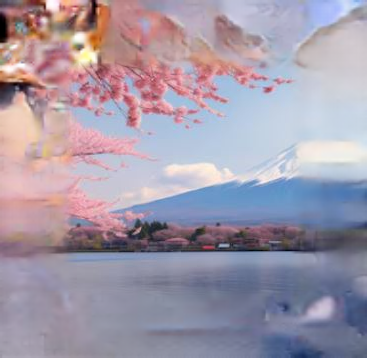

In [14]:
Image.fromarray((output*255).astype(np.uint8))